In [1]:
import glob
import os
import pprint
import traceback
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [2]:
 def tflog2pandas(path: str) -> pd.DataFrame:
    """convert single tensorflow log file to pandas DataFrame
    Parameters
    ----------
    path : str
        path to tensorflow log file
    Returns
    -------
    pd.DataFrame
        converted dataframe
    """
    DEFAULT_SIZE_GUIDANCE = {
        'compressedHistograms': 1,
        'images': 1,
        'scalars': 0,  # 0 means load all
        'histograms': 1,
    }
    runlog_data = pd.DataFrame({'metric': [], 'value': [], 'step': []})
    try:
        event_acc = EventAccumulator(path, DEFAULT_SIZE_GUIDANCE)
        event_acc.Reload()
        tags = event_acc.Tags()['scalars']
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {'metric': [tag] * len(step), 'value': values, 'step': step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print('Event file possibly corrupt: {}'.format(path))
        traceback.print_exc()
    return runlog_data

In [3]:
experiments = ['drq_robot-True_pr-True_aa-fixed_a-05', 'drq_robot-True_pr-False_aa-False', 'drq_robot-True_pr-True_aa-fixed', 'drq_robot-True_pr-True_aa-reward']

In [3]:
experiments = ['drq_robot-True_pr-True_aa-reward-fast']

In [4]:
path = '../../../output/final/fetch-push-final/'
exp_dict = {}
for exp in experiments:
    n = 3
    if exp == 'drq_robot-True_pr-False_aa-False':
        n = 1
    for i in range(n):
        tb = glob.glob(os.path.join(path, f'{exp}_{i}/tb/*'))
        if exp in exp_dict:
            exp_dict[exp].append(tb[0])
        else:
            exp_dict[exp] = tb

In [5]:
exp_dict = {k: list(map(lambda x: tflog2pandas(x), iter(v))) for k, v in exp_dict.items()}

In [6]:
exp_dict2 = {}
for k, v in exp_dict.items():
    df = pd.DataFrame()
    for frame in v:
        df = df.append(frame, ignore_index=True)
    split = k.split('_')
    name = ''
    if split[2] == 'pr-False':
        name = 'no teacher'
    if split[3] == 'aa-reward' or 'aa-reward-fast':
        name = 'adaptive alpha'
    if split[3] == 'aa-fixed':
        if len(split) >= 5 and split[4] == 'a-05':
            name = 'alpha=0.5'
        else:
            name = 'alpha=1.0'
    df['algo'] = name
    exp_dict2[k] = df

In [7]:
logs = pd.DataFrame()
for frame in exp_dict2.values():
    logs = logs.append(frame, ignore_index=True)

In [8]:
logs = logs.sort_values(by=['algo'])

In [ ]:
state_paths = ['../../../output/fetch-push-ae-ensemble/SAC_ensemble_0/tb/events.out.tfevents.1663166503.udo.1368770.0',
              '../../../output/fetch-push-ae-ensemble/SAC_ensemble_1/tb/events.out.tfevents.1663233381.udo.1495043.0',
              '../../../output/fetch-push-ae-ensemble/SAC_ensemble_2/tb/events.out.tfevents.1663267582.udo.1495043.1']

state_frame = pd.DataFrame()
for path in state_paths:
    df = tflog2pandas(path)
    df['algo'] = 'sac-state'
    state_frame = state_frame.append(df, ignore_index=True)

In [ ]:
all_logs = state_frame.append(logs, ignore_index=True)

In [21]:
all_logs.to_pickle('results/push/graph_data.pkl')

In [10]:
all_logs = pd.read_pickle('results/push/graph_data.pkl')

In [14]:
def plot(data, metric, name, y_low, y_high, image_name=None, color_palette="colorblind", dashes=None, legend=True, size=(20,10), legend_offset=-0.11, legend_ncol=5):
    fig = plt.figure(figsize=size)
    fig.patch.set_facecolor('white')
    plt.ticklabel_format(scilimits=[-5,3])
    

    # set style and context
    sns.set_context("notebook")
    sns.set(style='whitegrid', font_scale=2)

    # create graph
    graph = sns.lineplot(data=data[data['metric']==metric], 
                        x='step', 
                        y='value', 
                        hue='algo',
                        style='algo',
                        ci='sd',
                        palette=color_palette,
                        dashes=dashes)

    # set legend options
    handles, labels = graph.get_legend_handles_labels()
    if legend:
        fig.legend(loc='lower center', 
                   bbox_to_anchor=(0.5, legend_offset), 
                   fancybox=True, 
                   shadow=True, 
                   ncol=legend_ncol, 
                   prop={'size': 19})

    # graph options
    graph.legend([],[], frameon=False)
    graph.set(xlabel='Environment Steps', ylabel=name)
    #graph.title.set_text('Fetchpush')
    #graph.title.set_size(26)
    graph.set_ylim(y_low, y_high)
    graph.set_xlim(0, 2000000)
    #fig.tight_layout(pad=2.0)
    if image_name != None:
        plt.savefig(image_name, bbox_inches='tight')#, pad_inches=0.1)

In [15]:
dashes = {algo: () if i <= 9 else (6,4) for i, algo in enumerate(all_logs['algo'].unique())}

In [16]:
colors = {algo: sns.color_palette('colorblind', all_logs['algo'].nunique())[i] for i, algo in enumerate(all_logs['algo'].unique())}

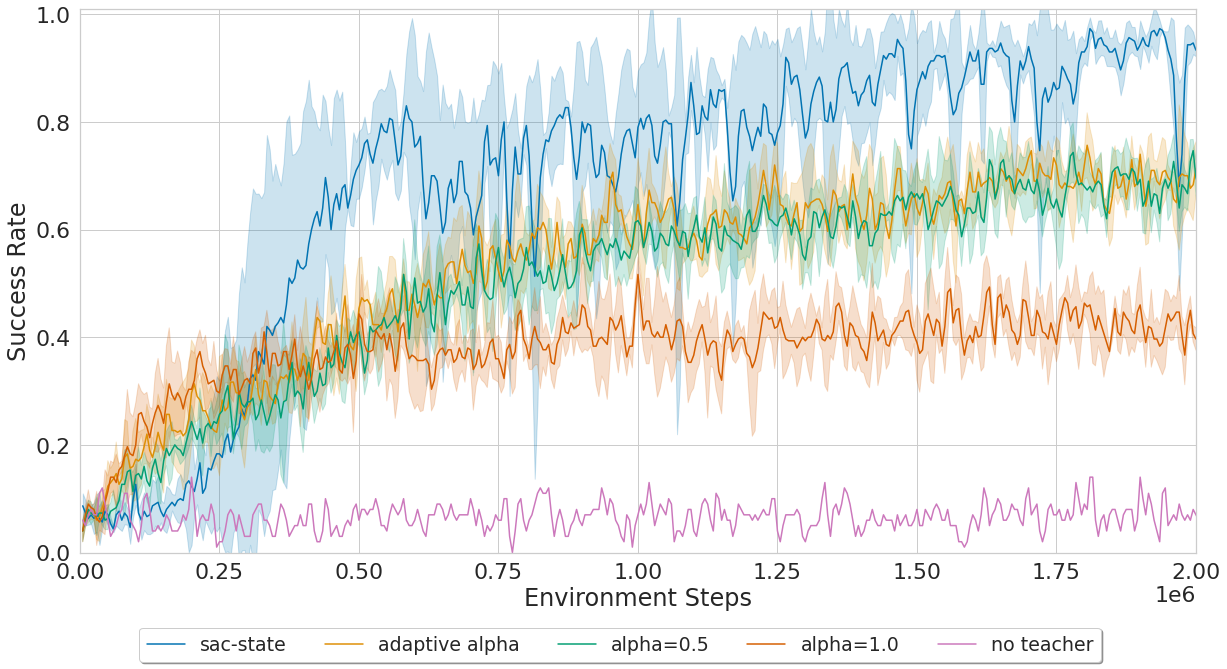

In [19]:
plot(all_logs[all_logs['step']%5000==0], 'train/success_rate', 'Success Rate', 0, 1.01, 'results/push/success_rate.png', colors, dashes, legend_offset=-0.04, legend=True)

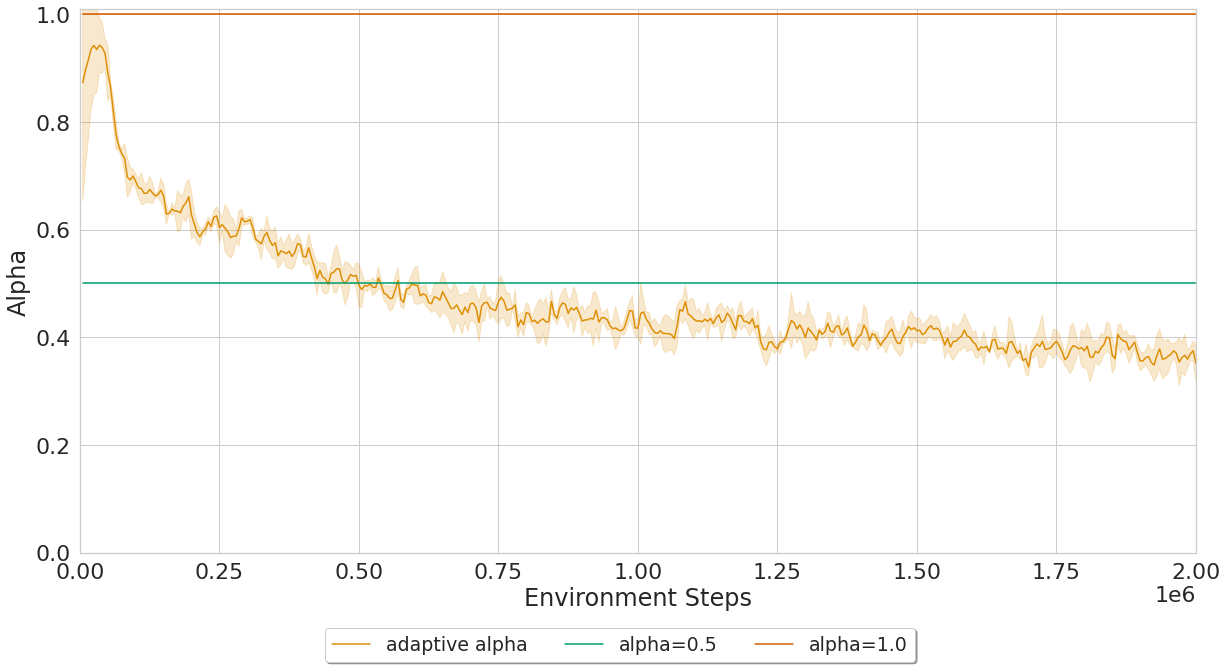

In [20]:
plot(all_logs[all_logs['step'] % 5000 == 0], 'train/preference_reward/alpha', 'Alpha', 0, 1.01, 'results/push/alpha.png', color_palette=colors, dashes=dashes, legend_offset=-0.04, legend=True)

In [4]:
def rgb_to_hex(rgb):
    return '%02x%02x%02x' % rgb

In [10]:
rgb_to_hex(tuple([int(255*x) for x in colors['adaptive alpha']]))

'de8f05'